In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf

from scipy.stats import norm
from scipy.optimize import fsolve, minimize
import matplotlib.pyplot as plt
'''
12/1/21
have math down
next step is to optimize what is optimal spread based off IV download
functionize

'''

'\n12/1/21\nhave math down\nnext step is to optimize what is optimal spread based off IV download\nfunctionize\n\n'

In [4]:
df=pd.DataFrame()

In [5]:
dates=['12-03-21','12-10-21','12-17-21']
ticker='es'
data=yf.download(ticker, end='2021-12-03',start='2015-09-01')
df=df.append(data)
df.reset_index(inplace=True)
    
    
    

[*********************100%***********************]  1 of 1 completed


In [6]:
#finding historical volatility

In [7]:
df['pct']=df['Adj Close'].pct_change()
df_pct=df['pct'].iloc[1:]
vol=df_pct.rolling(20).std(ddof=1).dropna()

In [8]:
vol

20      0.010463
21      0.011284
22      0.011395
23      0.010439
24      0.010671
          ...   
1571    0.009312
1572    0.009219
1573    0.012163
1574    0.012179
1575    0.012362
Name: pct, Length: 1556, dtype: float64

In [9]:
df_pct_vol=df_pct.to_numpy()

In [10]:
np.std(df_pct_vol[0:20],ddof=1)

0.010463271896155446

In [11]:
#finding it in numpy to confirm value
period = 20
vol_numpy = np.zeros( (df_pct_vol.size - period + 1, ))

for i in range(df_pct_vol.size - period + 1):
    vol_numpy[i] = np.std( df_pct_vol[i:i + period], ddof = 1)
    
#print(vol_numpy)

In [12]:
np.allclose(vol.to_numpy(), vol_numpy)

True

In [ ]:
#finding stock price from its volatilty from call spread

put_call_parity = call-put - strike+1 ^rfr(expiry-today)

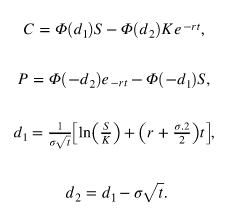

In [7]:
def call_price(sigma, S, K, r, t):
    'sigma=vol, s=stock , k=strike, r = rfr, t=time'
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    return C

def put_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

In [6]:
def equation_system_1(x, C_1, C_2, K_1, K_2, r, t):
    '''
    stock comes in as vector
    
    '''
    S = x[0]
    sigma = x[1]
    
    res = np.zeros(2) #2 elements | residual
    
    res[0] = call_price(sigma, S, K_1, r, t) - C_1
    res[1] = call_price(sigma, S, K_2, r, t) - C_2
    
    return res

In [2]:
# i don't love this nice for risk/reward

t = 43 / 365.0
r = 0.02

#  Strikes
K_1 = 270 #selling lower
K_2 = 290

#  Option prices
C_1 = 14.40
C_2 = 7.70

In [166]:
# i don't love this nice for risk/reward
'''
t = 43 / 365.0
r = 0.02

#  Strikes
K_1 = 270 #selling lower
K_2 = 290

#  Option prices
C_1 = 14.40
C_2 = 7.70

#  agrs define
args = (C_1, C_2, K_1, K_2, r, t)

x = np.array([200, 0.3])
x = fsolve(equation_system_1, x, args = args)
print(x)
spread=K_2-K_1
net_collect=C_1-C_2
collect=spread-net_collect
collect_pct=net_collect/spread
breakeven=K_1+(C_1-C_2)
risk=1-collect_pct
print('calced stock price: ', round(x[0],2),
      'spread: ',spread,
      'collect:' , round(net_collect,2), 
      'collect_pct:',"{:.0%}".format(collect_pct),
      'break even', breakeven ,
      'max risk:', "{:.0%}".format(risk))

[200.    0.3]
calced stock price:  200.0 spread:  20 collect: 6.7 collect_pct: 34% break even 276.7 max risk: 66%


C:\Users\Dan\AppData\Local\Temp/ipykernel_2224/3654190962.py:3: RuntimeWarning: invalid value encountered in log
  np.log(S/K) + (r + sigma**2 / 2.) * t  )


In [134]:
a=x[0]
a

100.0

In [135]:
#stock price, implied vol

In [5]:
def objective(x, C_1, C_2, K_1, K_2, r, t):
    S = x[0]
    sigma = x[1]
    
    res = np.zeros(2)
    
    # calculate the error of each leg
    res[0] = call_price(sigma, S, K_1, r, t) - C_1
    res[1] = call_price(sigma, S, K_2, r, t) - C_2
    
    #  Construct and return sum of squared errors
    J = res[0]**2 + res[1]**2
    
    return J

def constraint(x):
    C = np.zeros(2)
    
    # using 0.01 rather than 0 for the stock and vol minimum value to avoid potential divide-by-zero issues
    C[0] = x[0] - 0.01
    C[1] = x[1] - 0.01
    
    return C

# set constraint dict
cons = {'type':'ineq', 'fun': constraint}

#  agrs define
args = (C_1, C_2, K_1, K_2, r, t)

#  first guess of price and vol
x = np.array([100, 0.3])

#  solve optimizate
x = minimize(objective, x, args = args, constraints = cons)
print(x)

     fun: 266.65000000000003
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([100. ,   0.3])


In [7]:
#  We need to know the vol [sigma]. using the values from above to check answer
sigma = .56

#  using the spread price from above for debug
spread = C_1 - C_2

def spread_system_2(x, spread,  K_1, K_2, sigma, r, t):
    S = x
    
    #  Construct the equation as noted above
    C_1 = call_price(sigma, S, K_1, r, t)
    C_2 = call_price(sigma, S, K_2, r, t)
    
    return C_1 - C_2 - spread

args = (spread,  K_1, K_2, sigma, r, t)
S = fsolve(spread_system_2, 100, args = args)
print(S,C_1,C_2)

[262.10138318] 14.4 7.7


In [139]:
#finding porbability of touch price using monte carlo

# 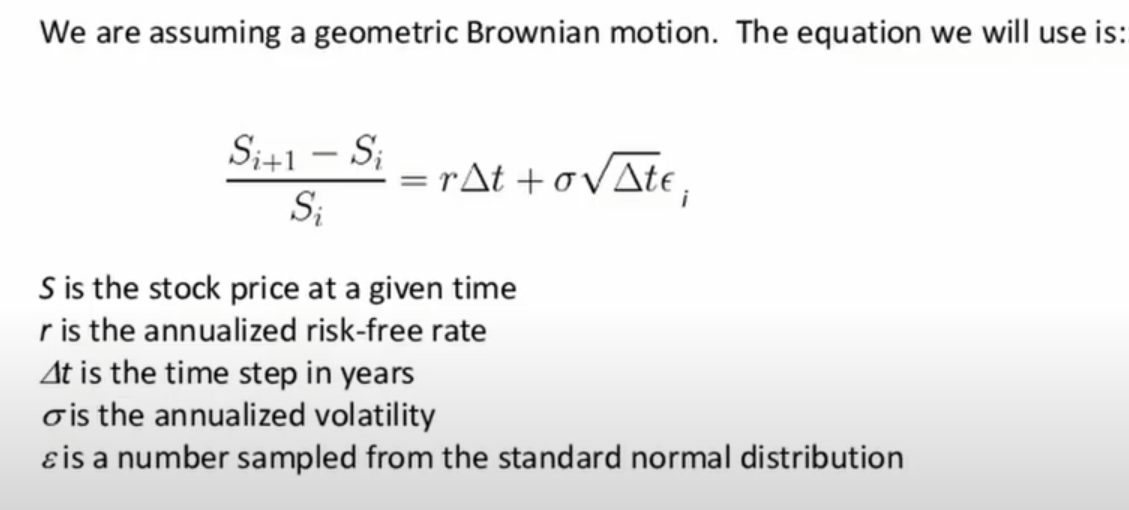


 using square root of volatility to to rescale with interest rate
 then running simulation to see how many times stock price touches that target number 
 then estimate that probabilty by target / # of runs

#
delta t is time step in years
sigma is implied vol anualized with a 1 std dev

In [8]:

def monte_carlo_sim(samples,days,sigma,stock_price,break_even):
    
    dt = 1.0 #assuming 1 day timestep
    r=0.02/252 #making assumption for rfr for easy of reuse
    sigma=sigma/np.sqrt(252)
    epsilon = np.random.normal( size = (samples, days) )
    ds_s = r * dt + sigma * epsilon
    
    prices = np.zeros( (epsilon.shape[0], epsilon.shape[1] + 1) )
    
    prices[:, 0] = stock_price
    for i in range(days):
        prices[:, i+1] = prices[:, i] + ds_s[:, i] * prices[:, i]

    #  Find the unique indices which meet our touch~ breakeven.
        ind = np.where( prices >= break_even)
        U = np.unique( ind[0] )

# calc/print the probability of a touch at break even
    print('probability of break even', float(len(U)) / float(samples) )
#plotting   
    for i in range(days):
        prices[:, i+1] = prices[:, i] + ds_s[:, i] * prices[:, i]
    
    for i in range(days):
        plt.plot(np.linspace(0,days,days+1),prices[i,:],'k',alpha=0.5)
    plt.xlabel('time days')
    plt.ylabel('stock price')
    plt.grid(True)
    plt.show()

probability of break even 0.8514


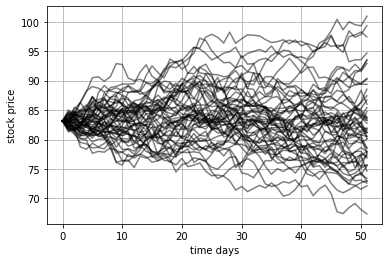

In [9]:
a=monte_carlo_sim(samples=10000,days=51,sigma=.22,stock_price=83.15,break_even=83.92)

In [173]:
equity=1000
exp_rtrn=50.94
win_prob=.79
loss_prob=1-win_prob

kelly_pct=(exp_rtrn*win_prob-loss_prob)/exp_rtrn
optimal_bet=kelly_pct*equity
optimal_kelly_frac=(kelly_pct*equity*.33)
print('bet size % based on kelly '"{:.0%}".format(kelly_pct))
print('optimal bet amount based on kelly:', round(optimal_bet,2))
print('optimal bet amount based on kelly fractional:', round(optimal_kelly_frac,2))

bet size % based on kelly 79%
optimal bet amount based on kelly: 785.88
optimal bet amount based on kelly fractional: 259.34
